# Решение ДЗ семинара 8
## Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [25]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import TTestIndPower
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

### Загрузка данных

In [26]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./test.xlsx')
df = pd.read_excel('./test.xlsx')

In [27]:
df.head(2)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [29]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [30]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [31]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

Анализируя исходные данные, делаем предварительный вывод:
1. Пустых данных в наборе нет
2. Менять типы данных в датасете для сокращения объема и ускорения работы смысла нет
3. Данные разбиты примерно поровну 5016/4984 - система сплитования в первом приближении, сработала нормально.
4. Отрицательных значений выручки REVENUE нет, т.е. ошибочных значений в этом поле нет.
5. Поле VARIANT_NAME содержит всего два значения: 'variant' и 'control', следовательно, в датасете результаты из двух групп, ошибочных значений в этом поле нет.
6. Поле USER_ID идентифицирует пользователя.
- Мы позволяем пользователю несколько раз участвовать в эксперименте (пользователь несколько раз в ходе эксперимента приходил к нам на сайт за покупками). Мы могли этому пользователю при разных покупках показывать разные версии сайта, поэтому исключать записи датасета с дублирующимися USER_ID смысла нет, это уменьшит объем выборки и сделает ее менее репрезентативной, т.к. мы отбросим часть валидных данных. Т.о. набор df можно использовать для дальнейшего анализа.
- Также можно попробовать убрать из набора данных пользователей, которые попали в обе группы: 'variant' и 'control', снизив объем выборки, и оставив в ней только уникальных пользователей, это набор данных df_unic.

Также интересно проанализировать, влияют ли отсортированные нами дублирующиеся пользователи на результат анализа.

In [32]:
# Избавимся от дублирующихся записей.

v = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
more_than_one_types = v.query('VARIANT_NAME > 1')
df_unic = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [33]:
# количество записей:
# (в исходном наборе, в очищенном от дубликатов наборе, удаленных из датасета записей)
df.shape[0], df_unic.shape[0], df.shape[0]-df_unic.shape[0]

(10000, 6070, 3930)

In [34]:
# разделение датасетов для отображения и анализа
# raw - неочищенные данные
# unic - очищенные данные
raw_control = df.query('VARIANT_NAME == "control"')
raw_variant = df.query('VARIANT_NAME == "variant"')
unic_control = df_unic.query('VARIANT_NAME == "control"')
unic_variant = df_unic.query('VARIANT_NAME == "variant"')

In [35]:
# объем выборок для сырых данных:
len(raw_control), len(raw_variant)

(4984, 5016)

In [36]:
# объем выборок для почищенных данных:
len(unic_control), len(unic_variant)

(3026, 3044)

In [37]:
# оценим нормальность распределения выручки в выборках
alpha = 0.05

st = shapiro(df.REVENUE)
print('Распределение raw {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))
st = shapiro(df_unic.REVENUE)
print('Распределение unic {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]))

Распределение raw не нормальное

Распределение unic не нормальное



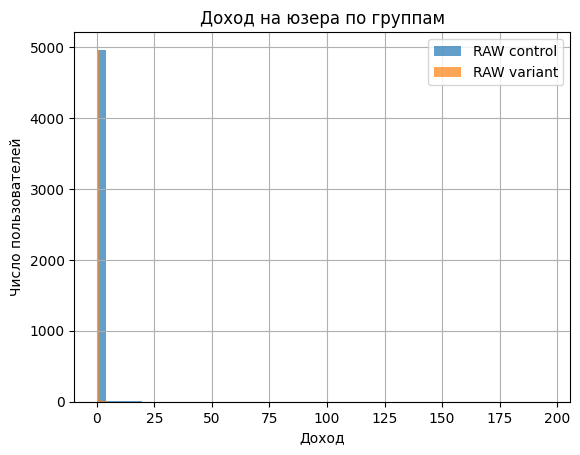

In [38]:
# строим гистограмму распределения выручки между группами control и variant в наборе RAW
raw_control.REVENUE.hist(bins = 50, alpha =0.7, label='RAW control')
raw_variant.REVENUE.hist(bins = 50, alpha =0.7, label='RAW variant')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

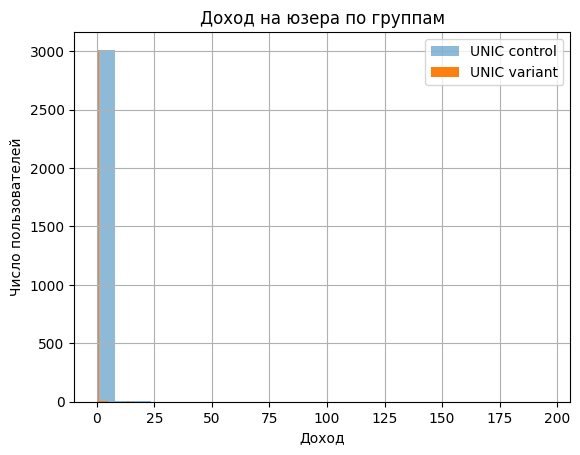

In [39]:
# строим гистограмму распределения выручки между группами control и variant в наборе UNIC
unic_control.REVENUE.hist(bins = 25, alpha =0.5, label='UNIC control')
unic_variant.REVENUE.hist(bins = 25, alpha =1, label='UNIC variant')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

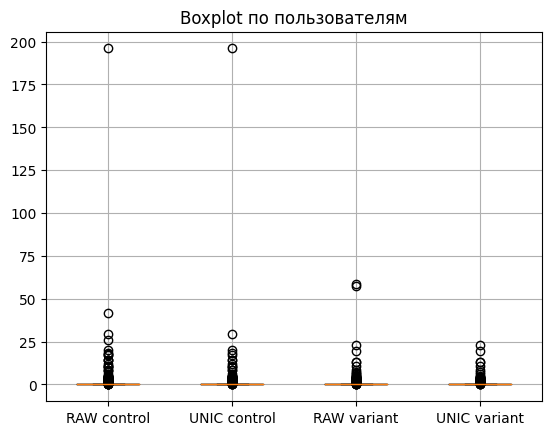

In [40]:
# строим boxplot для всез наборов данных: RAW и UNIC
plt.boxplot([raw_control.REVENUE, unic_control.REVENUE, raw_variant.REVENUE, unic_variant.REVENUE],
            labels=['RAW control', 'UNIC control', 'RAW variant', 'UNIC variant'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Из графических представлений наборов данных не видно особой разницы между распределением в исходном наборе RAW и в почищенном UNIC. В почищенных данных выбросов меньше, но есть сомнения, что они являются статистически значимыми.

In [49]:
# оценим есть ли статистически значимая разница в наборах
alpha = 0.05

mw = mannwhitneyu(x=raw_control.REVENUE.values,
                  y=raw_variant.REVENUE.values)
print('В распределениях данных в группах control и variant исходного набора данных RAW {}обнаружены статистически значимые отличия\n'.format( {True:'не ', False:''}[mw[1] > alpha]))
mw = mannwhitneyu(x=unic_control.REVENUE.values,
                  y=unic_variant.REVENUE.values)
print('В распределениях данных в группах control и variant почищенного набора данных UNIC {}обнаружены статистически значимые отличия\n'.format( {True:'не ', False:''}[mw[1] > alpha]))


В распределениях данных в группах control и variant исходного набора данных RAW не обнаружены статистически значимые отличия

В распределениях данных в группах control и variant почищенного набора данных UNIC не обнаружены статистически значимые отличия



In [50]:
# также интересно: есть ли статистически значимые отличия между исходными и почищенными данными
alpha = 0.05

mw = mannwhitneyu(x=raw_control.REVENUE.values,
                  y=unic_control.REVENUE.values)
print('В данных группы control исходного набора данных RAW и почищенного UNIC {}обнаружены статистически значимые отличия\n'.format( {True:'не ', False:''}[mw[1] > alpha]))
mw = mannwhitneyu(x=raw_variant.REVENUE.values,
                  y=unic_variant.REVENUE.values)
print('В данных группы variant исходного набора данных RAW и почищенного UNIC {}обнаружены статистически значимые отличия\n'.format( {True:'не ', False:''}[mw[1] > alpha]))


В данных группы control исходного набора данных RAW и почищенного UNIC не обнаружены статистически значимые отличия

В данных группы variant исходного набора данных RAW и почищенного UNIC не обнаружены статистически значимые отличия



In [43]:
ttest_ind(raw_control.REVENUE.values, raw_variant.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.268403803110966, pvalue=0.20469713432410774)

In [44]:
ttest_ind(unic_control.REVENUE.values, unic_variant.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.403762252371675, pvalue=0.1604844017690842)

In [45]:
ttest_ind(raw_control.REVENUE.values, unic_control.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=-0.332197483417307, pvalue=0.7397530366874661)

In [46]:
ttest_ind(unic_variant.REVENUE.values, raw_variant.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=-0.4827066351292274, pvalue=0.6293171920767298)

Кросс-сравнение выборок из групп RAW и UNIC также показывает отсутствие статистически значимых отличий. p-value везде > alpha=0.05

Анализ исходного набора данных RAW и почищенного от дублирующихся записей набора UNIC по критерию Манна-Уитни и Т-тест показали отсутствие статистически значимых отличий в наборах. Т.е. данные можно было не чистить.

## Расчет мощности для наборов RAW и UNIC


d = (M1 – M2) / S_pooled

S_pooled = sqrt( (std1^2 + std2^2) /2 )

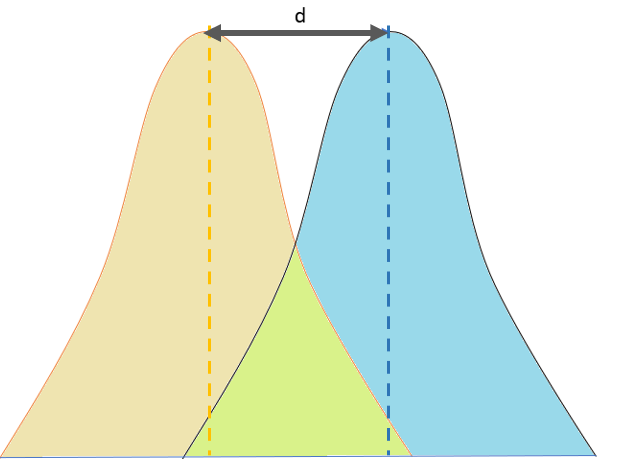

In [47]:
# расчет мощности для RAW
raw_control_mean = raw_control.REVENUE.values.mean()
raw_variant_mean = raw_variant.REVENUE.values.mean()
raw_control_std = raw_control.REVENUE.values.std()
raw_variant_std = raw_variant.REVENUE.values.std()
raw_Spooled = np.sqrt((raw_control_std**2 + raw_variant_std **2)/ 2)
raw_effect=float((raw_control_mean - raw_variant_mean) / raw_Spooled)
raw_n=len(raw_control.REVENUE)

alpha = 0.05

analysis = TTestIndPower()
raw_power_result = analysis.solve_power(raw_effect, power=None, nobs1=raw_n, ratio=1.0, alpha=alpha)

raw_effect, raw_power_result


(0.025398300337756648, 0.2450283117022621)

In [48]:
# расчет мощности для UNIC
unic_control_mean = unic_control.REVENUE.values.mean()
unic_variant_mean = unic_variant.REVENUE.values.mean()
unic_control_std = unic_control.REVENUE.values.std()
unic_variant_std = unic_variant.REVENUE.values.std()
unic_Spooled = np.sqrt((unic_control_std**2 + unic_variant_std **2)/ 2)
unic_effect=float((unic_control_mean - unic_variant_mean) / unic_Spooled)
unic_n=len(unic_control.REVENUE)

alpha = 0.05

analysis = TTestIndPower()
unic_power_result = analysis.solve_power(unic_effect, power=None, nobs1=unic_n, ratio=1.0, alpha=alpha)

unic_effect, unic_power_result

(0.0360905955737073, 0.2893670730459213)

Мощности тестов для исходного набора данных RAW (24.5%) и для почищенного набора UNIC (28.9%) являются достаточно низкими, так что для принятия решения по вопросу: какой тест control или variant обеспечивает бОльшую выручку, не хватает данных.

Эксперименты могли быть поставлены или проведены некорректно, или мала длительность. Тесты следует перезапустить.